In [1]:
# Setup the dependency for running on gogole colab <https://colab.research.google.com/>
#
if 'google.colab' in str(get_ipython()):
    !pip install lightkurve
    !git clone https://github.com/orionlee/PH_TESS_I_LightCurveViewer.git
    
    # add the notebook directory so path so that the python files there can be imported
    import sys
    sys.path.append('./PH_TESS_I_LightCurveViewer')
    print('Dependency setup for google colab completed.')

In [2]:
import lightkurve as lk
from lightkurve_ext import of_sector, of_sectors, of_2min_cadences
import lightkurve_ext as lke
import tic_plot as tplt

import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib

import pandas as pd
import astropy as astropy
from astropy import units as u
from astropy.io import fits

from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator)

from importlib import reload # useful during development to reload packages

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

%matplotlib inline


In [3]:
display(HTML("""
<script>
function addSideNav() {
    let ctr = document.getElementById('nav-ctr');
    if (ctr) { ctr.remove(); }
    const sections = [
        ['#input-tic', 'Enter TIC'],
        ['#lc-all', 'Lightcurves - all'],
        ['#lc-interactive', 'Interactive'],
        ['#lc-zoomed-in', 'Zoomed-in'],
        ['#lc-transits', 'Transit Times'],
        ['#lc-background-sso', 'Bkg / SSO'],
        ['#lc-detrend', 'Detrend'],
        ['#lc-fold', 'Folding'],
        ['#lc-period', 'Period / BLS'],
        ['#lc-river', 'River Plot'],
    ];
    // avoid and arrow functions and string with backslash n 
    // they cause parsing failure with jupyter's display(HTML())
    function toASection(sec) {
      return `              <li><a href="${sec[0]}">${sec[1]}</a></li>`;
    }
    const sectionsHTML = 
        sections.map(toASection).join(`
`);
    document.body.insertAdjacentHTML('beforeend', `
<div id="nav-ctr">
    <style>
        #nav-side {
            position: fixed; right: 2.5vh; top: 2.5em; z-index: 999;
            background-color: #feefc3; border: 1px solid lightgray; border-radius: 10%;
            padding: 0.25em 2ch 0.25em 0.5ch;        
        }
        #nav-side.expand {
            padding: 0.25em 2ch;                
        }
        #nav-side-expand {
            display: none;
        }
        .expand #nav-side-expand {
            display: block;
        }
        #nav-side-ctl-hideshow:before {
            content: "<<";
        }
        .expand #nav-side-ctl-hideshow:before {
            content: ">>";
        }
    </style>
    <div id="nav-side" class="expand"
         style="">
        <div id="nav-side-ctl-hideshow" style="float: right; cursor: pointer;" onclick="this.parentElement.classList.toggle('expand');"></div>
        <div id="nav-side-expand">
            Jump to:
            <ul>
${sectionsHTML}
            </ul>
        <div id="nav-side-expand">
    </div>
</div>

`);
}
addSideNav();
</script>
"""));


## Enter TIC
<a name="input-tic">

In [4]:
# Run All Above and this cell to start
#
# TIC form Subject metadata
# reload(tplt)
# reload(lke)

# tic = 55525572 # 1st Planet Candidate from PHT
tic = 286923464 # TOI 1271.01, Known planet HD118203 b around a sub giant (unusual) TESS observations helped to improve stellar model  https://astrobites.org/2019/12/26/tess-reveals-hd118203-b-transits-after-13-years/

use_cache = 'yes'


lcf_coll = None
try:
    # Load the light_curves into collection
    lcf_coll = lke.download_lightcurve(f"TIC{tic}", mission='TESS', exptime='short', download_dir='./data', use_cache=use_cache, display_search_result=True)
    if lcf_coll is not None and len(lcf_coll) > 0:
        print(f"TIC {tic} \t#sectors: {len(lcf_coll)} ; {lcf_coll[0].meta['SECTOR']} - {lcf_coll[-1].meta['SECTOR']}")
        print(f"   sector {lcf_coll[-1].meta['SECTOR']}: \tcamera = {lcf_coll[-1].meta['CAMERA']} ; ccd = {lcf_coll[-1].meta['CCD']}")
    else:
        print(f"TIC {tic}: no data")
finally:
    # a beep to remind the users that the data has been downloaded
    tplt.beep()


TIC 286923464 	#sectors: 3 ; 15 - 22
   sector 22: 	camera = 3 ; ccd = 2


## Look for non-standard lightcurves

In [ ]:
# Helper in the context of:
# https://github.com/lightkurve/lightkurve/issues/1048
    
from collections import OrderedDict
from astropy.table import Table

def filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC', 'QLP'], include_if_none_found=True):
    # create an empty table with the same set of columns
    res_t = sr.table[np.zeros(len(sr), dtype=bool)].copy()
    
    uniq_missions = list(OrderedDict.fromkeys(sr.mission))
    # for each mission (e.g., TESS Sector 01), select a row based on author priority
    for m in uniq_missions:
        sr_mission = sr[sr.mission == m]
        added = False
        for author in author_priority:
            sr_author = sr_mission[sr_mission.author == author]
            if len(sr_author) > 0:
                res_t.add_row(sr_author.table[0])  # add the first (typically the only) row
                # Note: if there are multiple products from the same author, e.g, SPOC with exptime 120 and 20,
                # only the first one is added
                added = True
                break
        if include_if_none_found and not added:
            res_t.add_row(sr_mission.table[0])
            
    return lk.SearchResult(table=res_t)


# search to see if there is products from other sources
sr = lk.search_lightcurve(f"TIC{tic}", mission='TESS')
display(sr)

#  fi
sr_filtered = filter_by_priority(sr, author_priority=['TESS-SPOC', 'QLP'], include_if_none_found=True)

if (len(sr_filtered) != len(sr)):
    print('Filtered some results:')
    display(sr_filtered)


In [ ]:
lc = sr_filtered[0].download(download_dir='data')
# lc = sr[sr.mission == 'TESS Sector 30'].download(download_dir='data')
ax = lc.normalize(unit='percent').remove_outliers(sigma=7).scatter();
ax.set_title(f"{lc.meta['LABEL']}, sector {lc.meta['SECTOR']} ; by {lc.meta['AUTHOR']}");

if False:  # zoom in to possible transits
#     t0, period, label_prefix = 1356.588, 4.26956, 'TOI 310.01'
    t0, period, label_prefix = 1362.55, 999, 'Dip'

    surround_time = 3.0
    
    t_times = lke.get_transit_times_in_lc(lc, t0, period)
    print(f"Derived Transit times: {t_times}")
    t0 = t_times[0]
    ax.axvline(t0, ymax=0.2, c='blue', linestyle='--', label=f"t0 ~= {t0} ({tplt.as_4decimal(t0 - lc.meta['TSTART'])})")
    ax.set_xlim(t0 - surround_time / 2, t0 + surround_time / 2)
    # ax.set_ylim(99.94, 100.1)
    ax.legend()

print(f"TSTART: {lc.meta['TSTART']}");  # To aid relative time conversion

In [ ]:
# optional filter, for cases the MAST search returned more than one targets
lcf_coll = lke.of_tic(lcf_coll, tic)

# optional filter, for cases the MAST search also returned 20-second data and I want to ignore them.
lcf_coll = lke.of_2min_cadences(lcf_coll)

lcf_coll

## Lightcurves - all sectors
<a name="lc-all">

Sectors: [15, 16, 22] (3)
Observation period range / data range:
  Sector 15: 1711.361442715728 - 1737.399999818419
   (cam 4)   1711.362137026201 - 1737.4062499191018
  Sector 16: 1738.648606818424 - 1763.316949581586
   (cam 4)   1738.6493011458838 - 1763.316255237362
  Sector 22: 1899.321399028552 - 1926.496548627605
   (cam 3)   1899.309593171361 - 1926.495854305018


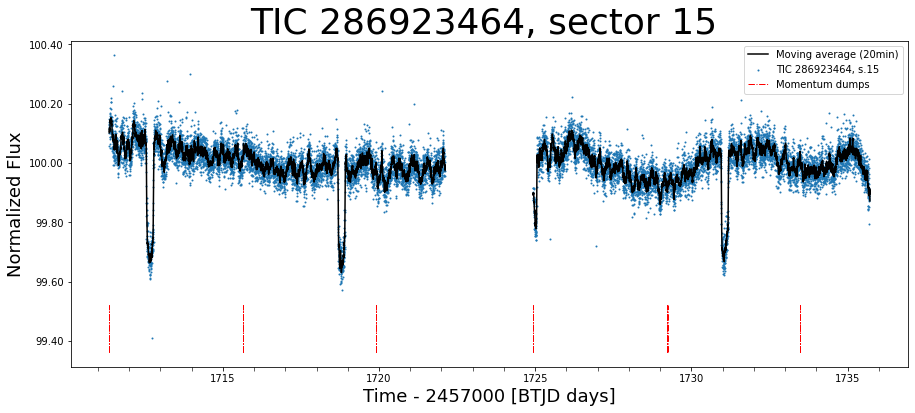

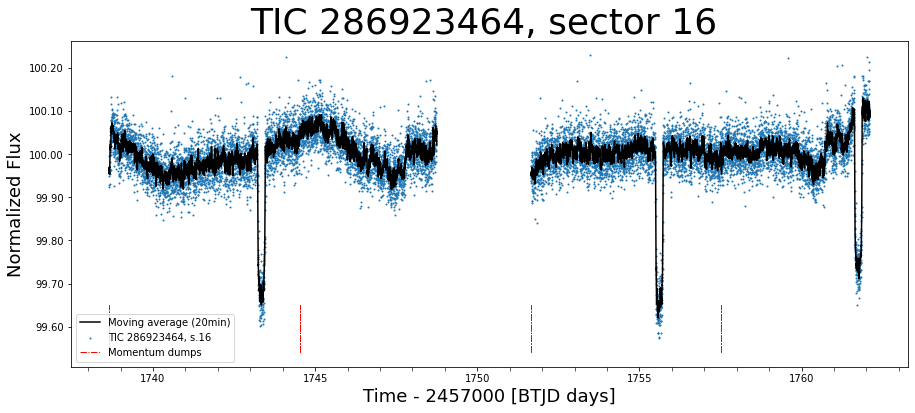

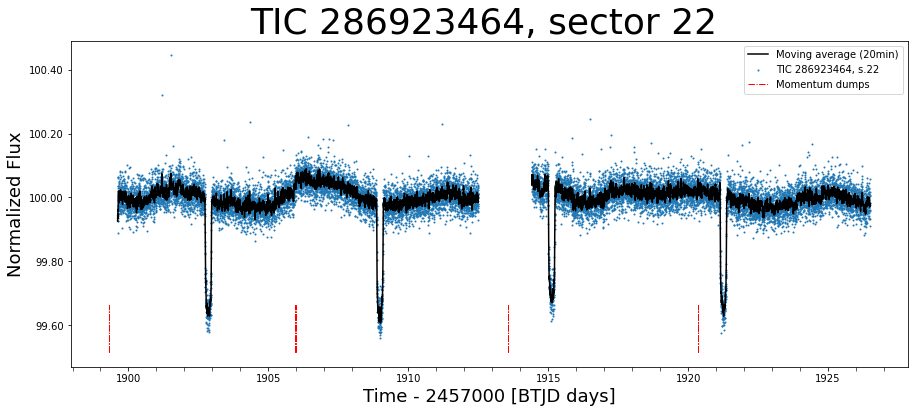

In [6]:
# plot all the data
reload(tplt)

%matplotlib inline

tplt.print_data_range(lcf_coll)

axs = tplt.plot_all(
                    lcf_coll[lcf_coll.sector >= 1]  # of_sectors(lcf_coll, 1, 13, 34, 35)   # lcf_coll[np.in1d(lcf_coll.sector, (3, 35))]   
#                     , flux_col = 'SAP_FLUX'
                    , moving_avg_window='20min' # None # '20min' # '30min'
#                     , lc_tweak_fn=lambda lc: lc.remove_outliers(sigma=6) 
#                     , lc_tweak_fn=lambda lc: lc[:3000]
#                     , ax_fn=lambda: plt.figure(figsize=(30,10)).gca()
              , ax_fn=lambda: plt.figure(figsize=(15,6)).gca()
#                   , use_relative_time=True
                    , mark_quality_issues=False
#                     , mark_momentum_dumps=False
#               , set_title=False
              , ax_tweak_fn=lambda ax: [
#                                             ax.set_ylim(97, 101.5),
                                       ]
             )

# axs[0].set_xlim(5.0, 6.5)
# axs[0].set_ylim(None, 120)

## Lightcurve - interactive
<a name="lc-interactive">

In [7]:
reload(tplt)
%matplotlib inline

# interactively view a lightcurve 
lcf = lcf_coll[-1]
# lcf = of_sector(lcf_coll, 26)
# lcf = sr[sr.mission == 'TESS Sector 30'].download(download_dir='data')  # from non standard products

sector = lcf.sector

#  From section 4.1.2 of the paper TOI catalog from TESS primary mission
#  https://arxiv.org/pdf/2103.12538.pdf
print('Fraction of flux in aperture attributed to the target: ', lcf.meta.get('CROWDSAP'))  # less reliable when it is < 0.8

print(f"TSTART: {lcf.meta['TSTART']}");  # To aid relative time conversion

# to zoom in to a particular region
# tplt.plot_lcf_interactive(lcf, figsize=(15, 8))

# variant to make zoom in to a specific dip eaiser
tplt.plot_transit_interactive(lcf, figsize=(30, 10)
#                               ,flux_col='SAP_FLUX'
                             );


Fraction of flux in aperture attributed to the target:  0.99945199
TSTART: 1899.321399028552


Output(layout=Layout(border='1px solid lightgray', padding='1em 0px'))

Output(layout=Layout(padding='1em'))

## Lightcurve - zoomed in
<a name="lc-zoomed-in">

Transits, zoomed-in


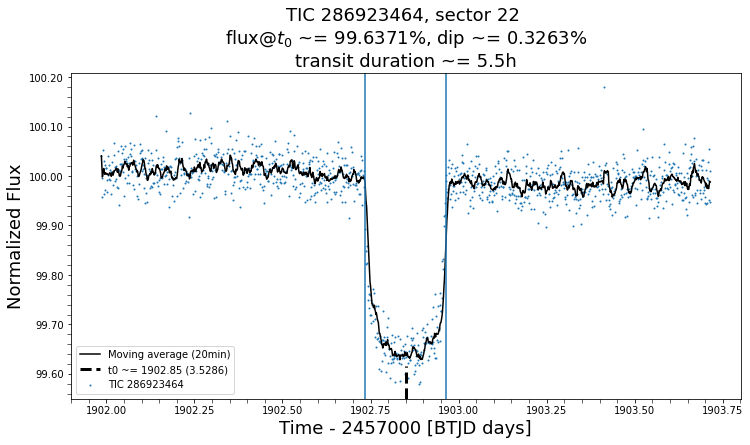

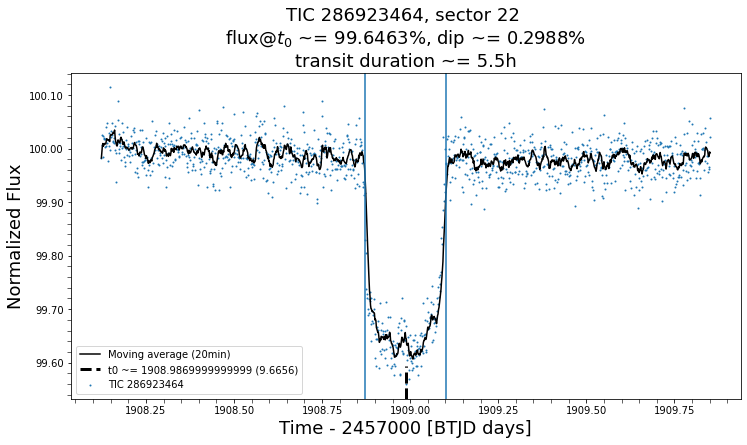

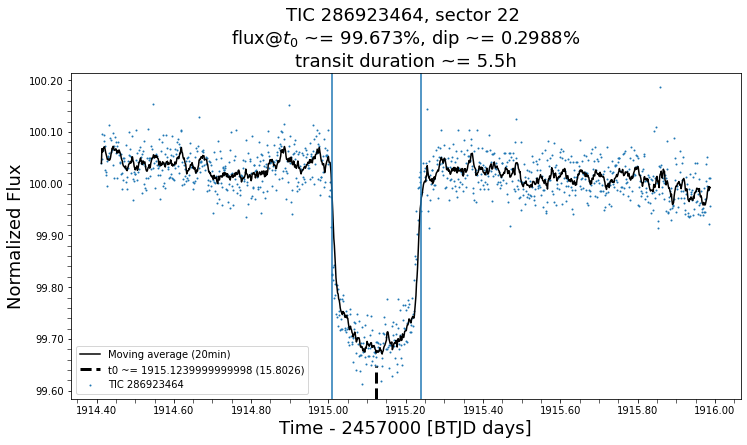

In [8]:
# Plots, zoomed-in around selected dips / transits
# reload(tplt)

%matplotlib inline

# transit_specs for calling plot_transits()
transit_specs = [
    dict(sector=22
         , t0 = 1902.85
         , steps_to_show = [0, 1, 2])
]
transit_defaults = dict(duration_hr = 5.5, period = 6.137, surround_time = 1.5)


def custom_lc_tweak(lc):
    res = lc
    res = res.remove_outliers(sigma=7)
    res = res.bin(time_bin_size=20 * u.min)
    res.meta.update(lc.meta)  #compensate LCv2 bug in bin
    return res

figsize = (12,6)  # (15, 9)  
axs = tplt.plot_transits(    
                         lcf_coll # [of_sectors(lcf_coll, 27)[1], of_sectors(lcf_coll, 28)[1]]
                         , transit_specs, transit_defaults
#                          , flux_col = 'SAP_FLUX'
                         , ax_fn=lambda: plt.figure(figsize=figsize).gca()    
                         , t0mark_ymax=0.1
                         , lc_tweak_fn=lambda lc: lc.remove_outliers(sigma=7)
#                          , lc_tweak_fn=custom_lc_tweak
                         , moving_avg_window='20min' # None # '30min' # '10min' # None, '20min' #  '30min'
#                          , set_title=False
                        , ax_tweak_fn=lambda ax: [
#                             ax.set_ylim(None, 100.75)
#                        , ax.axvline(2002.8274702863073, c='r', linestyle='--')
                        ]
                        )
# axs[0].set_ylim(None, 100.2)
print('Transits, zoomed-in');

In [9]:
# Understand the quality issues marked by dotted red line in plot_all()
for lcf in of_sectors(lcf_coll, 26):
    qual_time, qual_flags = lke.list_times_w_quality_issues(lcf)  # check PDCSAP_FLUX
    print(f"Sector {lcf.meta['SECTOR']}: ", [(tplt.as_4decimal(t), lk.utils.TessQualityFlags.decode(f)) for t, f in zip(qual_time, qual_flags)])
    

# Transit Times
<a name="lc-transits">

[1902.85, 1908.9869999999999, 1915.1239999999998, 1921.261]



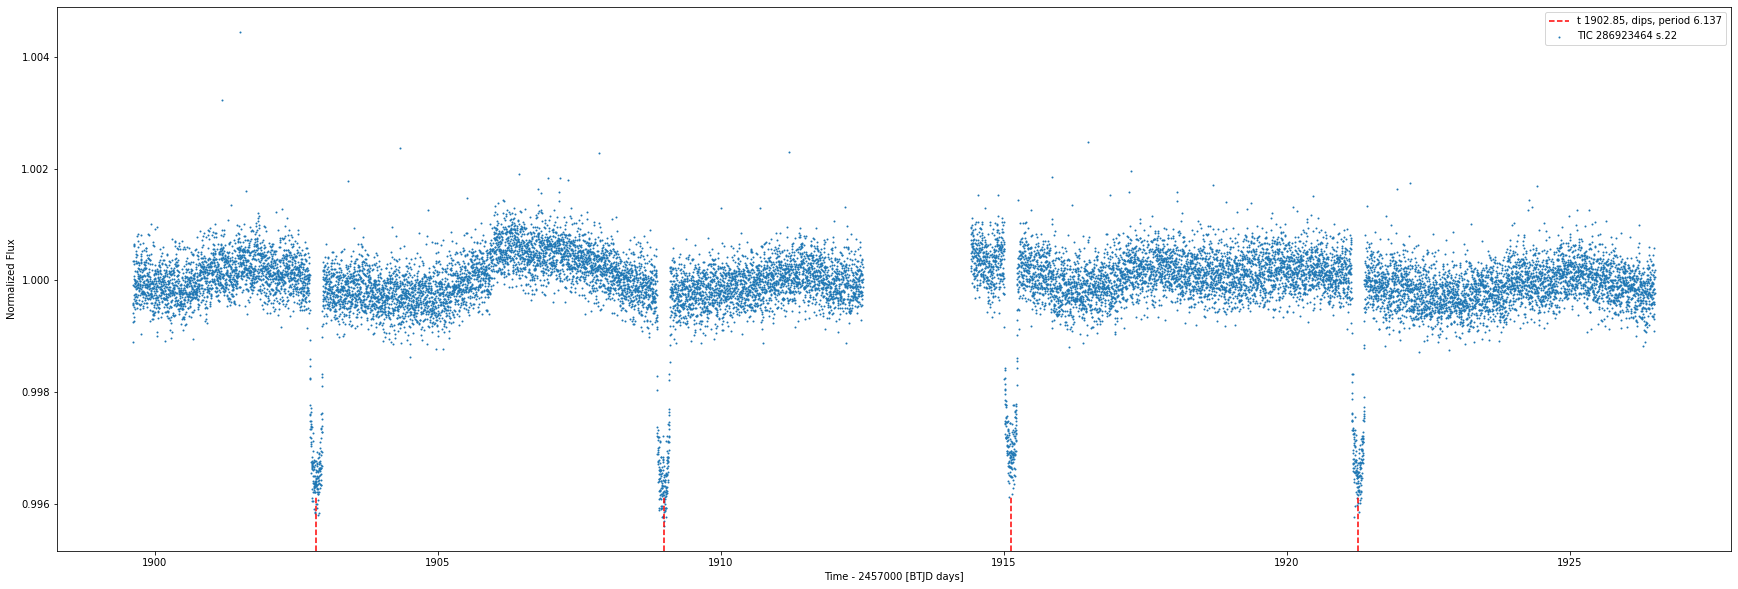

In [12]:
# reload(lke)

# %matplotlib widget
%matplotlib inline


# List transit times for other usages, e.g., inputs to LATTE
if True:
    ax = plt.figure(figsize=(30, 10)).gca()
#     ax = plt.figure(figsize=(15, 6)).gca()


#     lc = lcf_coll[-1].normalize(unit='percent').remove_outliers(sigma=5)
#     lc = of_sectors(lcf_coll, 34, 35, 36).stitch()
#     lc = lcf_coll[lcf_coll.sector >= 33].stitch()
#     lc = lcf_coll.stitch()
    lc = of_sectors(lcf_coll, sector).stitch()
    # non-standard products
#     lc = sr[0].download(download_dir='data')
    # lc = sr[sr.mission == 'TESS Sector 30'].download(download_dir='data')    
#     lc = lc[int(len(lc)*2/8):int(len(lc)*3/8)]  # to zoom in a section for short periods


#     t0, period, label_prefix = 2230.4, 74.6, 'possible TOI 2404.01 peer'  # deep dips

    # use the values from zommed-in section
    t0 = transit_specs[0].get('t0', transit_defaults.get('t0'))
    period = transit_specs[0].get('period', transit_defaults.get('period'))
    label_prefix = 'dips'
    

    transit_times = lke.get_transit_times_in_lc(lc , t0, period)
    print(transit_times)

    # now do the plotting
    if False: # then flatten
        window_length_days = 2/24
        lc, lc_trend = lc.flatten(window_length=lke.to_window_length_for_2min_cadence(window_length_days), return_trend=True)

    ax = lc.scatter(ax=ax, label=f"{lc.label} s.{getattr(lc, 'sector', 'N/A')}")
    
    legend_set = False
    for tt in transit_times:
        ax.axvline(tt, 0, 0.1, linestyle='--', color='r', label=f't {tt}, {label_prefix}, period {period}')
        if not legend_set:
            # hack so that only 1 legend entry for the axvline
            ax.legend()
            legend_set = True

# Dips that follow another pattern            
#     t0, period, label_prefix = 2258.2, 74.6, 'possible TOI 2404.01 peer'  # shallow dips
#     transit_times = lke.get_transit_times_in_lc(lc , t0, period)
#     print(transit_times)
#     for tt in transit_times:
#         ax.axvline(tt, 0, 0.1, linestyle='--', color='gray', label='c')

    
#     ax.set_ylim(None, 102.5)
#     x_min, x_duration = 2284, 4
#     ax.set_xlim(x_min, x_min + x_duration)
#     ax.set_xlim(2255, 2265)
    print('');


C:\pkg\_winNonPortables\Anaconda3\lib\site-packages\lightkurve\lightcurve.py:702: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  LightkurveWarning)


Text(0.5, 1.0, 'TIC 350520348')

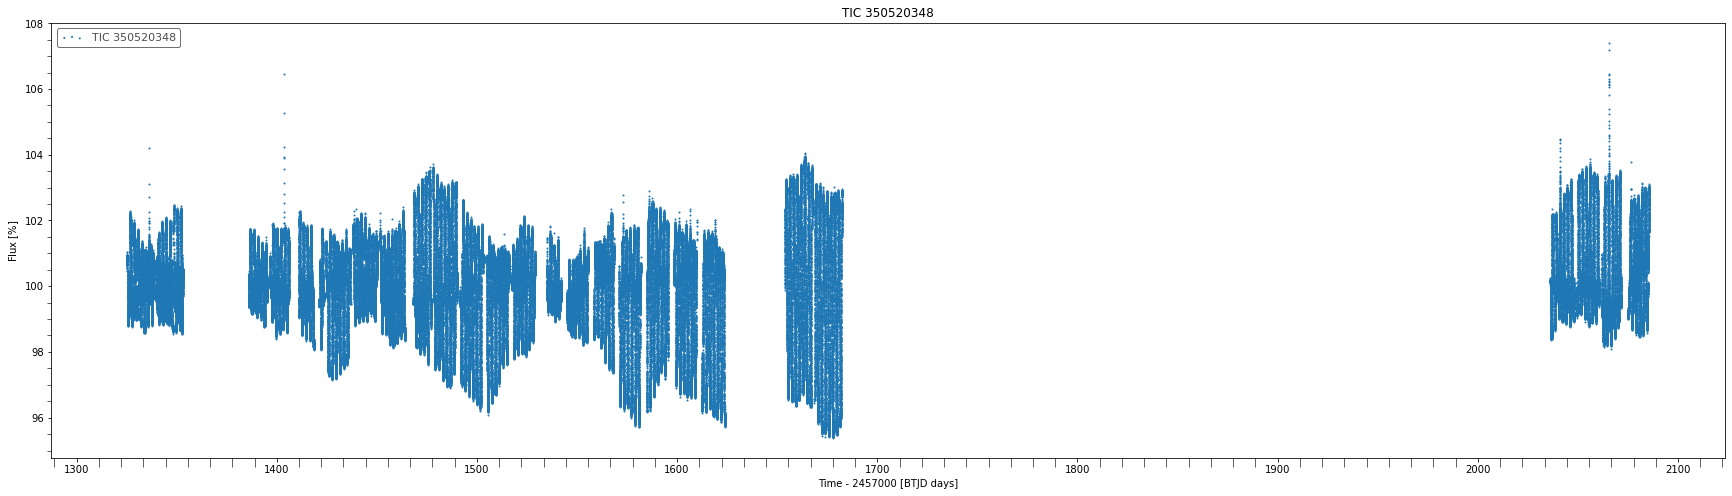

In [12]:
# custom plots, typical for stiching lightcurves from multiple sectors

# lcf_coll.plot()

lc = None
lc = lcf_coll[lcf.sectors >= 1].stitch()  # of_sectors(lcf_coll, 23, 24, 25, 26):
lc = lc.normalize(unit='percent')


# lc = lc.flatten(window_length=lke.to_window_length_for_2min_cadence(window_length_days))
ax = plt.figure(figsize=(30, 8)).gca()
lc.scatter(ax=ax)
# ax.set_ylim(98.5, 102)
ax.xaxis.set_minor_locator(AutoMinorLocator(9))
ax.tick_params(axis='x', which='minor', length=9)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis='y', which='minor', length=4)
ax.set_title(lc.label);


## Detrend
<a name="lc-detrend">

In [ ]:
# detrend using 
# 1. built-in  flatten (with savgol filter), and 
# 2. spline-based flatten

def myFig():
    return plt.figure(figsize=(15, 6))

lcf = lcf_coll[0]
lc = lcf.PDCSAP_FLUX

t0 = transit_specs[0]['t0']
period = transit_specs[0].get('period', transit_defaults['period'])    
t0, period = 1797.2085199998692, 5.6235742  # deep dips
# lc = lc[0:math.floor(len(lc)/2)] # optional zoom in to better see the details, or speed up the process
dips = lke.get_transit_times_in_lc(lc, t0, period)

if True:
    t0, period = 1794.4139899997972, 5.6235742  # shallow dips
    dips_more = lke.get_transit_times_in_lc(lc, t0, period)
    dips = dips + dips_more
    
print('Num of observations to be flattened: ', len(lc))

# lcf.SAP_FLUX.normalize(unit='percent').scatter(ax=myFig().gca())
# plt.title('SAP_FLUX')

ax = lc.normalize(unit='percent').scatter(ax=myFig().gca())
tplt.markTimes(ax, dips, ymax=0.1)
plt.title('PDCSAP_FLUX')

# window_length: chosen to be slightly larger than a transit period, flattening out the mini flucutations.
window_length_days = 8/24
lc_flattened, lc_trend = lc.flatten(window_length=lke.to_window_length_for_2min_cadence(window_length_days), return_trend=True)
ax = lc_flattened.normalize(unit='percent').scatter(ax=myFig().gca())
tplt.markTimes(ax, dips, ymax=0.1)
plt.title(f'PDCSAP_FLUX.flatten(), window_length: {window_length_days} days')
ax.set_ylim(None, 101.5)


# the smaller the s (smoothing factor), the more flattened the result, i.e.,
# more variation is extracted as long-term trend
# s=1e7 fits okay for this subject after some trial and error
# comparing it with savgol_filter used by flattened(), it does not handle sudden dips in transits as well, 
# spline seems to either sawllow the dips in the trend, or smooth insufficient (leaving too much variation in the detrended)
spline_s = 8e6
lc_myFlattened, lc_myTrend = lke.flatten_with_spline_normalized(lc, return_trend=True, k=3, s=spline_s)
ax = lc_myFlattened.scatter(ax=myFig().gca())
tplt.markTimes(ax, dips, ymax=0.1)
plt.title(f'myFlattenNormalized(lc, s={spline_s})')

# Compare the trends from flattened vs spline
fig = myFig()
ax = fig.gca()
ax.scatter(lc_trend.time, lc_trend.normalize(unit='percent').flux, c='r', marker='.', label="flatten, aka, savgol_filter")
ax.scatter(lc_myTrend.time, lc_myTrend.normalize(unit='percent').flux, c='b', marker='.', label='spline')
tplt.markTimes(ax, dips, ymax=0.1)
fig.gca().legend()
plt.title('Compare the extracted trends');



## Fold
<a name="lc-fold">

C:\dev\lightkurve\src\lightkurve\lightcurve.py:998: LightkurveWarning: The light curve already appears to be in relative units; `normalize()` will convert the light curve into relative units for a second time, which is probably not what you want.
  LightkurveWarning,


lc_folded time scale:  None
lc_folded phase:  [-3.06802964 -3.06791853 -3.06736297 ...  3.06719258  3.06774814
  3.0684148 ]
odd  0.1 percentile:  99.61577685546874 %
even 0.1 percentile:  99.62981960296631 %
lc_folded time scale:  None
lc_folded phase:  [-6.13586297 -6.13464075 -6.13452964 ...  6.13558147  6.13569258
  6.1369148 ]


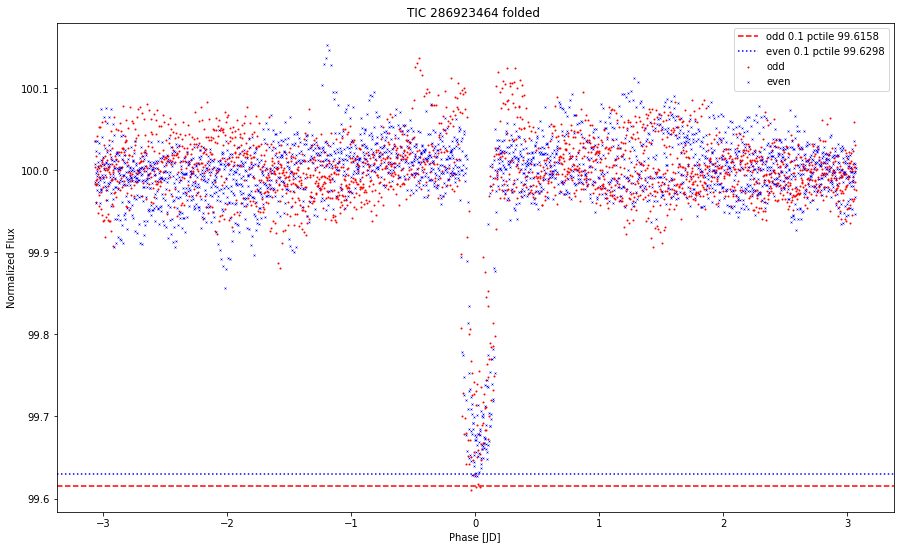

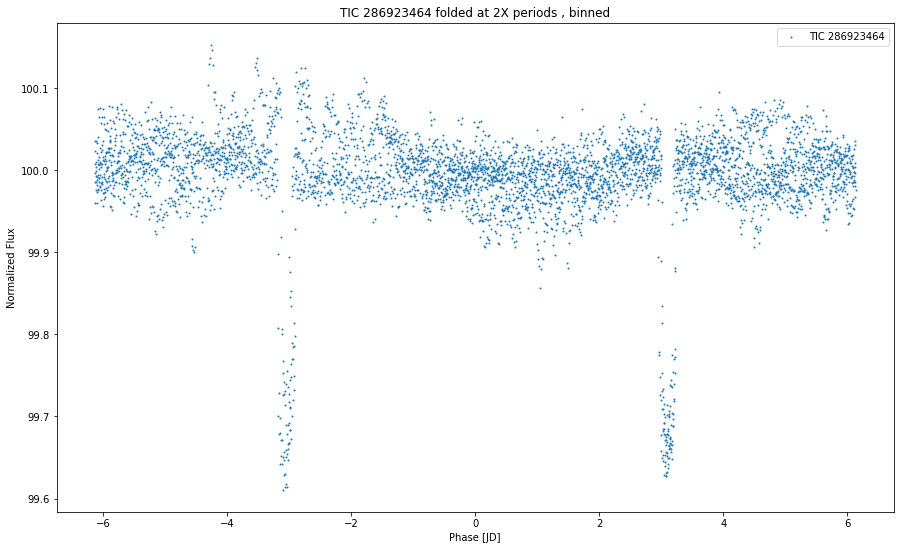

In [14]:
# Fold lightcurves

# optionally use only specific sectors
# lc = of_sectors(lcf_coll, 8,9,10,11,12,13,27).stitch()
# lc = lcf_coll[(lcf_coll.sector >= 27) & (lcf_coll.sector < 36)].stitch()
# lc = lcf_coll[lcf_coll.sector == sector].stitch()
# lc = lcf_coll[-1]
lc = lcf_coll.stitch()

lc = lc.normalize(unit='percent').remove_outliers(sigma=7)
lc_b = lc.bin(time_bin_size = 20 * u.minute)
lc_b.meta.update(lc.meta)

# t0, period, label_prefix = 1357.285, 10.09029, 'TOI 235.01'  #  TIC 229914020 (S0014-S0023) TCE_1 , # the primary eclipses

t0 = transit_specs[0]['t0']
period = transit_specs[0].get('period', transit_defaults['period'])
# t0, period = 1956.351030000019, 0.825645


# double to see 2 dips, and shift t0 a bit so that both dips can be seen clearly
# t0 = t0 + period / 4
# period = period * 2


def fold_and_plot(lc, title_extra=''):
    lc_folded = lc.fold(period=period, epoch_time=t0, epoch_phase=0)

    ax=plt.figure(figsize=(15, 9)).gca()
#     lc_folded[lc_folded.odd_mask].scatter(ax=ax, c='r', label='odd', marker='*')
    lc_f_odd = lc_folded[lc_folded.odd_mask]
    lc_f_odd.scatter(ax=ax, c='r', label='odd', marker='.', s=4)
    lc_f_even = lc_folded[lc_folded.even_mask]
    lc_f_even.scatter(ax=ax, c='b', label='even', marker='x', s=4)
    
    pct01_odd = np.nanpercentile(lc_f_odd.flux, 0.1)
    pct01_even = np.nanpercentile(lc_f_even.flux, 0.1)
    
    ax.axhline(pct01_odd * 100, c='r', linestyle='--', label=f"odd 0.1 pctile {tplt.as_4decimal(pct01_odd)}")
    ax.axhline(pct01_even * 100, c='b', linestyle='dotted', label=f"even 0.1 pctile {tplt.as_4decimal(pct01_even)}")

    ax.legend()    
    plt.title(f'{lc.label} folded {title_extra}')
    
    print('lc_folded time scale: ', lc_folded.time.scale)
    print('lc_folded phase: ', lc_folded.phase)
    print('odd  0.1 percentile: ', pct01_odd)
    print('even 0.1 percentile: ', pct01_even)
    return ax

def fold_2periods_and_plot(lc, title_extra=''):
    lc_folded = lc.fold(period=period * 2, epoch_time=t0, epoch_phase=period / 2)

    ax=plt.figure(figsize=(15, 9)).gca()
    lc_folded.scatter(ax=ax)
    
    ax.legend()    
    plt.title(f'{lc.label} folded at 2X periods {title_extra}')
    
    print('lc_folded time scale: ', lc_folded.time.scale)
    print('lc_folded phase: ', lc_folded.phase)
    return ax

ax = fold_and_plot(lc_b);
# ax.set_ylim(0.975, 1.01);
# ax.set_xlim(-0.1, 0.1);

fold_2periods_and_plot(lc_b, ', binned');


lc_folded time scale:  None
lc_folded phase:  [-3.06841264 -3.06835403 -3.06823866 ...  3.06818479  3.06820144
  3.06827534]
odd  0.1 percentile:  0.9963134450072989 %
even 0.1 percentile:  0.9961694106938701 %
lc_folded time scale:  None
lc_folded phase:  [-6.13685403 -6.13639956 -6.13634477 ...  6.13652749  6.13654424
  6.13677534]


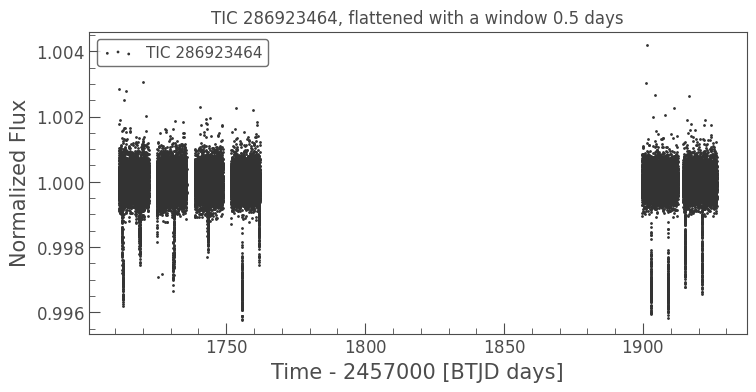

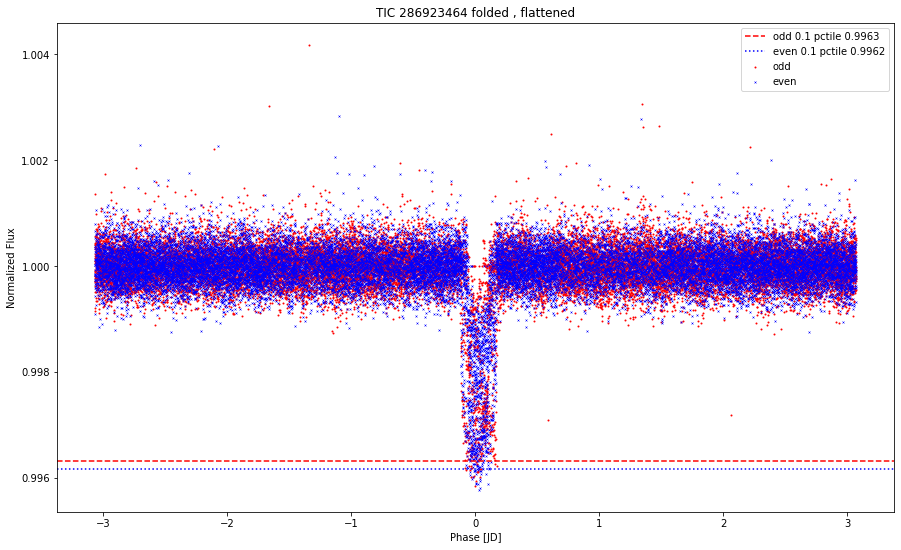

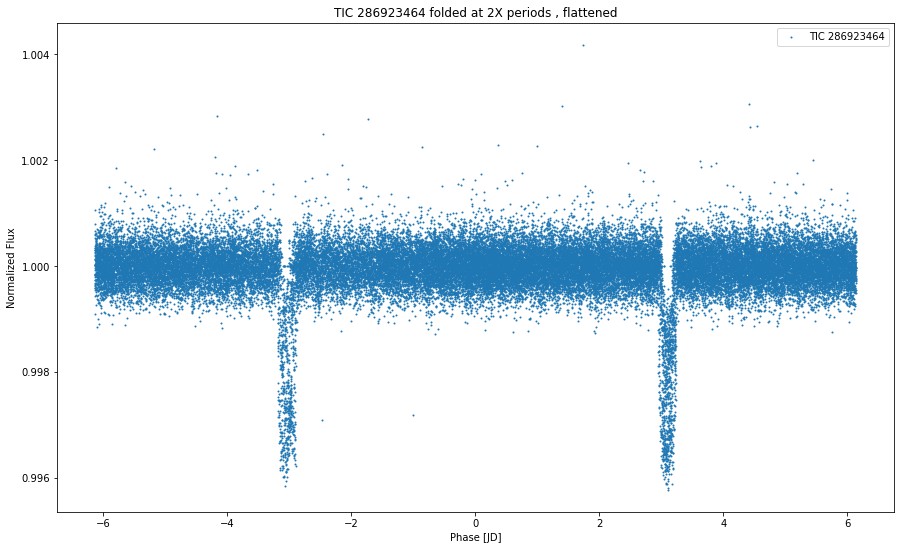

In [15]:
# Detrend then fold

window_length_days = 12 / 24
lc_flattened = lc.flatten(window_length=lke.to_window_length_for_2min_cadence(window_length_days))

# lc.scatter()
ax = lc_flattened.scatter()  # ax=ax, c='b'
ax.set_title(f'{lc.label}, flattened with a window {window_length_days} days')

fold_and_plot(lc_flattened, ', flattened');

fold_2periods_and_plot(lc_flattened, ', flattened');


## Period / BLS
<a name="lc-period">

In [24]:
# run BLS against all / subset of data 

# lc = of_sectors(lcf_coll).PDCSAP_FLUX.stitch()
# lc = lcf_coll[0].PDCSAP_FLUX
lc = of_sector(lcf_coll, sector).PDCSAP_FLUX
lc = lc.normalize()

print('Num of observations:', len(lc))
print('Observation elapsed time:', lc.time.max()  - lc.time.min())

# use the interactive transit period detection
#   caveat: un-sure if combining observations over time make sense for the algorithm
lc.interact_bls()

# if False: 
if False: 
    x_min = 1
    x_max = 20
    # Box Least Square assumes U-shaped transit model (rapid dips)
    pdg_bls = lc.remove_nans().to_periodogram(method='bls')
    print('BLS')
    pdg_bls.show_properties()
    ax = pdg_bls.plot()
    ax.set_title('BLS Periodogram, in period')
    ax.set_xlim(x_min, x_max)

    # Lomb Scargle better for general vairable curves with sin-like shape (gradual flucutation)
    pdg_ls = lc.remove_nans().to_periodogram(method='lombscargle')
    print('Lomb Scargle')
    pdg_ls.show_properties()
    ax = pdg_ls.plot(view='period')
    ax.set_title('Lomb Scargle Periodogram, in period')    
    ax.set_xlim(x_min, x_max)
    
    

Num of observations: 14146
Observation elapsed time: 24.98851849900575


C:\pkg\_winNonPortables\Anaconda3\envs\lkv2\lib\site-packages\ipykernel_launcher.py:5: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  """


## Lightcurve - background / SSO
<a name="lc-background-sso">


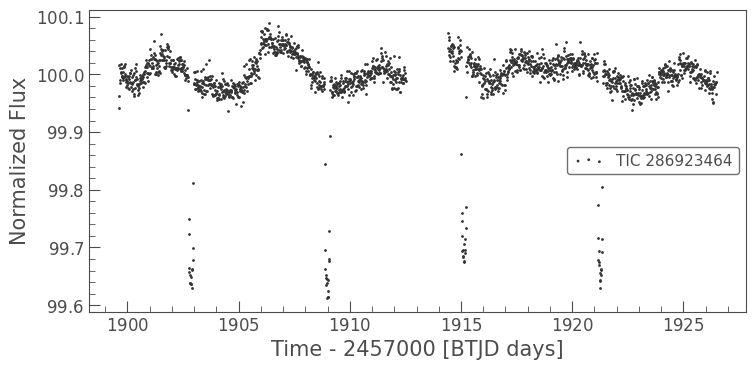

In [17]:
# check to see if there is any known solar system objects around a transit

# lcf = lcf_coll[-1]
lc = lcf_coll[lcf_coll.sector == sector][0]
lc = lc.normalize(unit='percent')
lc_b = lc.bin(time_bin_size = 20 * u.minute)  # bin it to speed up SSO search
if len(lc_b.meta) < 1: # to compensate lkv2 bugs in .bin() ; needed for query SSO
    lc_b.meta.update(lc.meta)  
lc_b.scatter(); 

t0= 1902.85


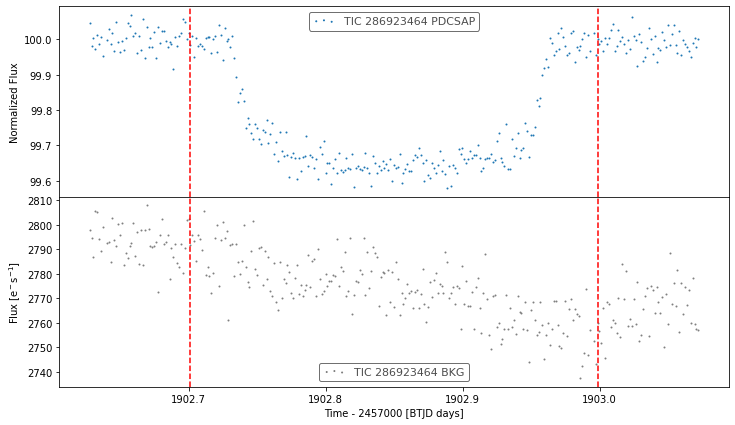

In [18]:
# reload(lke)

# Check the background flux for the duration in question
t0 = transit_specs[0].get('t0', transit_defaults.get('t0'))
period = transit_specs[0].get('period', transit_defaults.get('period'))

search_period = transit_specs[0].get('duration_hr', transit_defaults.get('duration_hr'))  * 1.3 / 24
plot_period = search_period * 1.5 
# t0 = t0 + period
search_start, search_end = t0 - search_period /2, t0 + search_period /2
plot_start, plot_end = t0 - plot_period /2, t0 + plot_period /2

# search_start, search_end = 2094.0, 2094.25
# plot_start, plot_end = 2093.90, 2094.35

plot_binned = False
fig, axs = plt.subplots(3 if plot_binned else 2, 1, sharex=True, figsize=(12, 10.5 if plot_binned else 7))
fig.subplots_adjust(hspace=0)

time_mask = (lc.time.value >= plot_start) & (lc.time.value <= plot_end)
if plot_binned: 
    lc_b[(lc_b.time.value >= plot_start) & (lc_b.time.value <= plot_end)].scatter(ax=axs[0])
lc[time_mask].scatter(ax=axs[-2], label=lc.label + ' PDCSAP')
if False:
    lc_sap = lcf.SAP_FLUX
    lc_sap[time_mask].scatter(ax=axs[-2], c='orange', label=lc.label + 'SAP')
lc_bkg = lke.get_bkg_lightcurve(lcf)
lc_bkg[time_mask].scatter(ax=axs[-1], color='gray')

if True and search_start is not None:
    for ax in axs:
        ax.axvline(search_start, linestyle='--', c='r')
        ax.axvline(search_end, linestyle='--', c='r')

print('t0=', t0);

In [250]:
lc_to_search = lc_b # use the binned one to speed up search
radius_in_arcsec = 168 # 315 # 168 ~= 8 pixels, should cover the range of entire Target Pixel file (11x11 pixels, with the target at center)
cadence_mask = (lc_to_search .time.value >= search_start) & (lc_to_search .time.value <= search_end)
# t_epoch = 2016.1330800000578
# duration_hr = 21.3918
# surround_time = 1
# duration = duration_hr / 24
# t0 = t_epoch
# df_sso = lc_to_search.query_solar_system_objects(cadence_mask=(lc.time >= t0 - (duration + surround_time)/2) & (lc.time <= t0 + (duration + surround_time)/2))

try:
    df_sso = lc_to_search.query_solar_system_objects(cadence_mask=cadence_mask, radius=radius_in_arcsec/60/60)
    display(df_sso)
finally: 
    tplt.beep();


Querying for SSOs: 100%|███████████████████████████████████████████| 16/16 [00:26<00:00,  1.68s/it]


,Num,Name,Class,Mv,epoch
0,233,Asterope,MB>Middle,12.4,2.459266e+06
0,233,Asterope,MB>Middle,12.4,2.459266e+06
0,233,Asterope,MB>Middle,12.4,2.459266e+06
0,233,Asterope,MB>Middle,12.4,2.459266e+06
0,233,Asterope,MB>Middle,12.4,2.459266e+06
0,233,Asterope,MB>Middle,12.4,2.459266e+06
0,233,Asterope,MB>Middle,12.4,2.459266e+06
0,233,Asterope,MB>Middle,12.4,2.459266e+06
0,233,Asterope,MB>Middle,12.4,2.459266e+06
0,233,Asterope,MB>Middle,12.4,2.459266e+06


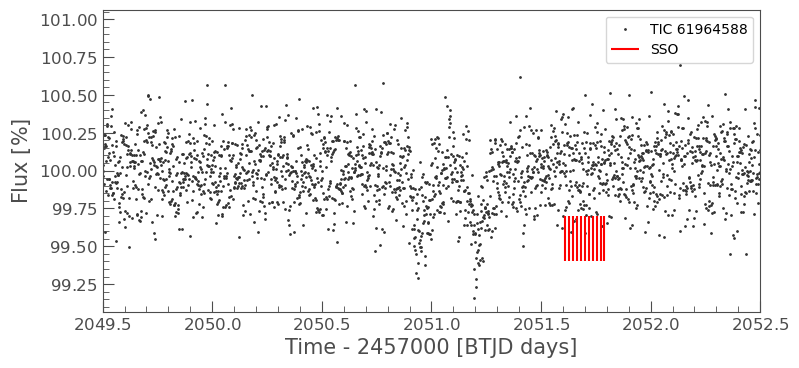

In [78]:
# Overlay SSO occurence with lightcurve

btjdref = 2457000.

sso_times = df_sso['epoch'].values - btjdref
# sso1_times = df_sso_narrow[df_sso_narrow.Num == 117362]['epoch'].values - btjdref
# sso2_times = df_sso_narrow[df_sso_narrow.Num == 16628]['epoch'].values - btjdref

lc = lcf.PDCSAP_FLUX
ax = lc.normalize(unit='percent').scatter()
ax.set_xlim(plot_start, plot_end)
# ax.set_ylim(None, 104)

ax.vlines(sso_times, 99.4, 99.7, color='red', label='SSO')
ax.legend();

## River Plot
<a name="lc-river">

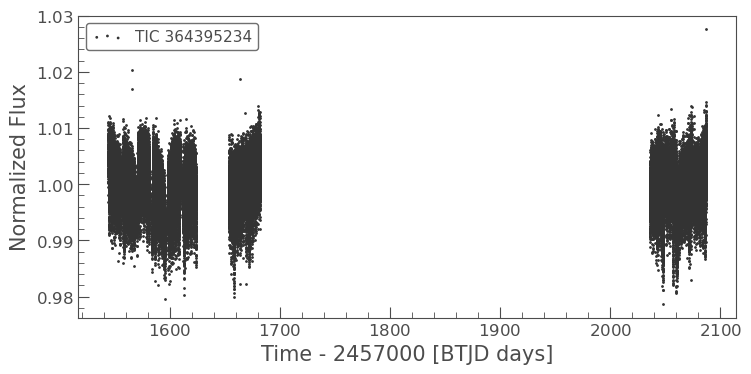

In [282]:
# lc = of_sectors(lcf_coll, 1,2,3,4,5,6,7,8,9,10,11,12,13).PDCSAP_FLUX.stitch()
lc = lcf_coll.SAP_FLUX.stitch()
lc.scatter();

<AxesSubplot:xlabel='Phase', ylabel='Normalized Flux'>

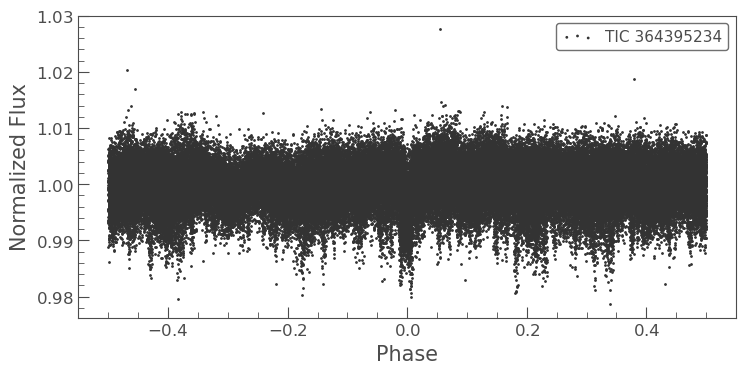

In [283]:
# lc_flattened, lc_trend = lc_trunc.flatten(window_length=lke.to_window_length_for_2min_cadence(length_day=1.5/24), return_trend=True)
# lc_flattened.scatter();
# t0, period = 1325.327, 17.089  # TOI 216.02
# t0, period = 1331.28531, 34.556  # TOI 216.01
t0, period = 1543.9775800001808, 14.259059   # TOI 1232.01
lc_folded = lc.fold(t0=t0, period=period)
lc_folded.scatter()


C:\pkg\_winNonPortables\Anaconda3\envs\Pyriod\lib\site-packages\lightkurve\lightcurve.py:1885: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(bs, cycs, ar.T, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)


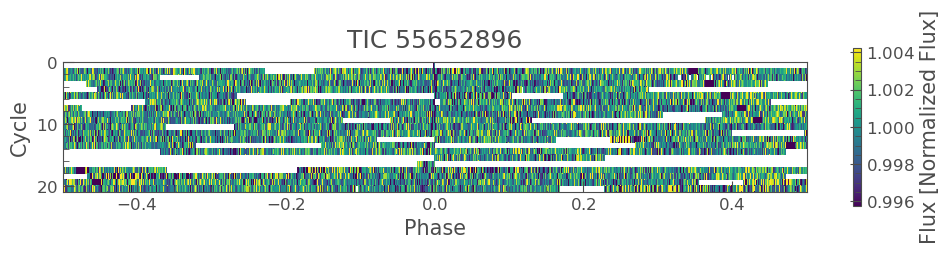

In [66]:
lc_folded.plot_river();


C:\pkg\_winNonPortables\Anaconda3\envs\Pyriod\lib\site-packages\lightkurve\lightcurve.py:1885: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(bs, cycs, ar.T, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)


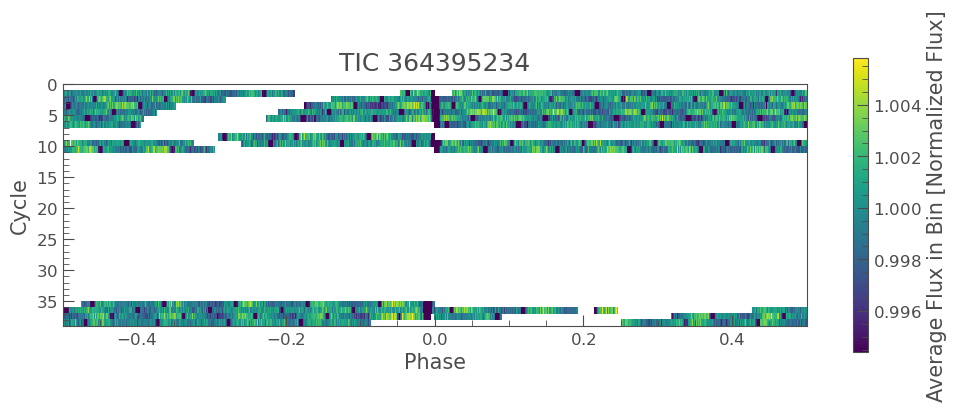

In [280]:
lc_folded.plot_river(bin_points=10, method='median');

C:\pkg\_winNonPortables\Anaconda3\envs\Pyriod\lib\site-packages\lightkurve\lightcurve.py:1885: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(bs, cycs, ar.T, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs)


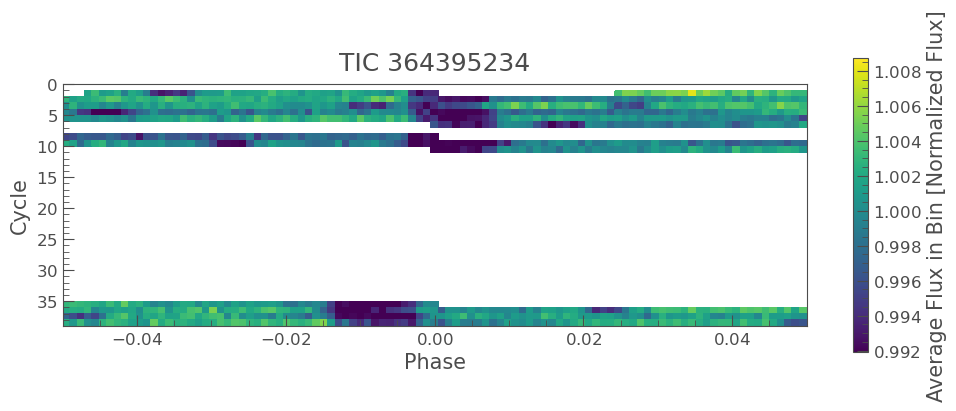

In [284]:
lc_folded.plot_river(bin_points=10, method='median', minimum_phase=-0.05, maximum_phase=0.05);


In [ ]:
# useful for visualizing transit time variation

lc = lcf_coll[0].PDCSAP_FLUX.normalize(unit='percent')

# from the https://exo.mast.stsci.edu/exomast_planet.html?planet=EPIC206103150b
period=4.1591289
t0=57007.4321 + 2400000.5 - 2454833 # convert from MJD to BKJD

# from the https://exo.mast.stsci.edu/exomast_planet.html?planet=EPIC206103150d
# period=9.03077
# t0= 57005.8693 + 2400000.5 - 2454833 # convert from MJD to BKJD
      
lc_folded = lc.fold(period=period, t0=t0)

print("t0:", t0)
lc_folded.scatter(ax=plt.figure(figsize=(15, 5)).gca())

lc.plot_river(period=period, t0=t0, ax=plt.figure(figsize=(15, 5)).gca()
             , minimum_phase=-0.015, maximum_phase=+0.015, method='median')


   ## Diagnose CBV correction

Optimized Over-fitting metric: 0.9981795232921128
Optimized Under-fitting metric: 0.8829468429928797
Optimized Alpha: 8.811e+03


array([<AxesSubplot:ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>,
       <AxesSubplot:title={'center':'Alpha = 8.811e+03'}, xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>],
      dtype=object)

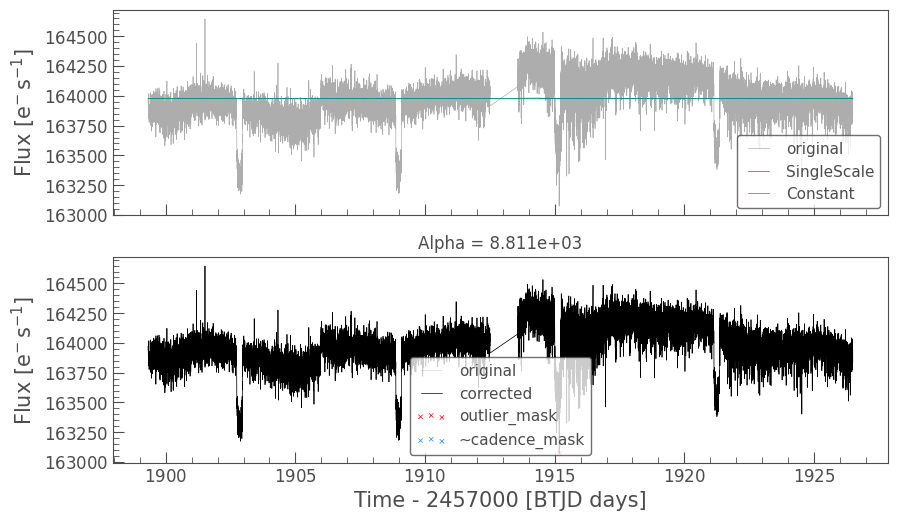

In [19]:
# Try to show the correction made to SAP (that is similar to how the official way done by SPOC)
# see: http://docs.lightkurve.org/whats-new-v2.html#%E2%9C%A8-New:-Remove-systematics-using-Cotrending-Basis-Vectors
# see: http://docs.lightkurve.org/tutorials/2-creating-light-curves/2-3-how-to-use-cbvcorrector.html

from lightkurve.correctors import CBVCorrector
def show_correction(lc):
    lc = lc.copy()
    # ensure we use the raw SAP lightcurve
    lc.flux = lc.sap_flux
    lc.flux_err = lc.sap_flux_err
    corrector = CBVCorrector(lc)
    lc_corrected = corrector.correct()
    return corrector, lc_corrected, lc
    
corrector, lc_corrected, lc_sap = show_correction(lcf_coll[-1])

corrector.diagnose()